In [41]:
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

To authorize access needed by Earth Engine, open the following URL in a web browser and follow the instructions. If the web browser does not start automatically, please manually browse the URL below.

    https://code.earthengine.google.com/client-auth?scopes=https%3A//www.googleapis.com/auth/earthengine%20https%3A//www.googleapis.com/auth/devstorage.full_control&request_id=p5osJeo0nuAl7fOGCpzZJy8P91mMjE36ghoce65_ViM&tc=D2R-kDTCAy3g9ZXbxArEpbsJnPyNfDJjw6P9Uqo5Ok8&cc=ob1wfJBbOPXxKF0B64kE9N_M4heb_zwX9-UNUqffmX4

The authorization workflow will generate a code, which you should paste in the box below.
Enter verification code: 4/1AfJohXlqePedkFdlc_vnwpyrHiPNyCH5nxzOn3Wz8P7SfDvaPT7uP1wYjBg

Successfully saved authorization token.


In [42]:
# Import the MODIS LST collection.
lst = ee.ImageCollection('MODIS/061/MOD11A1')

In [43]:
# Initial date of interest (inclusive).
i_date = '2022-01-01'

# Final date of interest (exclusive).
f_date = '2023-01-01'

# Selection of appropriate bands and dates for LST.
band = lst.select('LST_Day_1km', 'QC_Day').filterDate(i_date, f_date)

In [44]:
Imuris_lat = 30.7833
Imuris_lon = -110.8833
Imuris_point = ee.Geometry.Point(Imuris_lon, Imuris_lat)

In [45]:
Nogales_lat = 31.3099
Nogales_lon = -110.6363
Nogales_point = ee.Geometry.Point(Nogales_lon, Nogales_lat)

In [46]:
scale = 1000  # scale in meters
lst_imuris = band.mean().sample(Imuris_point, scale).first().get('LST_Day_1km').getInfo()
print('Imuris average daytime LST:', round(lst_imuris*0.02 -273.15, 2), '°C')

Imuris average daytime LST: 33.01 °C


In [47]:
scale = 1000  # scale in meters
lst_nogales = band.mean().sample(Nogales_point, scale).first().get('LST_Day_1km').getInfo()
print('Nogales average daytime LST:', round(lst_nogales*0.02 -273.15, 2), '°C')

Nogales average daytime LST: 28.75 °C


In [48]:
lst_Imuris_full = band.getRegion(Imuris_point, scale).getInfo()
lst_Imuris_full[:3] # Preview the output.

[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day'],
 ['2022_01_01',
  -110.88354709529314,
  30.780773210355406,
  1640995200000,
  None,
  2],
 ['2022_01_02',
  -110.88354709529314,
  30.780773210355406,
  1641081600000,
  14236,
  81]]

In [49]:
lst_Nogales_full = band.getRegion(Nogales_point, scale).getInfo()
lst_Nogales_full[:3] # Preview the output.

[['id', 'longitude', 'latitude', 'time', 'LST_Day_1km', 'QC_Day'],
 ['2022_01_01',
  -110.63201881573967,
  31.310779227985922,
  1640995200000,
  None,
  2],
 ['2022_01_02',
  -110.63201881573967,
  31.310779227985922,
  1641081600000,
  None,
  2]]

In [50]:
import pandas as pd
df = pd.DataFrame(lst_Nogales_full) #Convert list to dataframe
headers = df.iloc[0]   # Rearrange the header.
df = pd.DataFrame(df.values[1:], columns=headers)   # Rearrange the header.
df = df[['longitude', 'latitude', 'time', "LST_Day_1km" ]].dropna() # Remove rows with null data.
df[ "LST_Day_1km"] = pd.to_numeric(df[ "LST_Day_1km"], errors='coerce')    # Convert to numeric values.
df['datetime'] = pd.to_datetime(df['time'], unit='ms')  # Convert datetime to datetime values.
df = df[['time','datetime',  "LST_Day_1km"   ]] # take interest part
df.head()

,time,datetime,LST_Day_1km
2,1641168000000,2022-01-03,14290
3,1641254400000,2022-01-04,14468
4,1641340800000,2022-01-05,14412
5,1641427200000,2022-01-06,14577
6,1641513600000,2022-01-07,14565


In [51]:
def kelvin_to_celcius(t_kelvin):
    t_celsius =  t_kelvin*0.02 - 273.15
    return t_celsius
df['LST_Day_1km'] = df['LST_Day_1km'].apply(kelvin_to_celcius)
df.head()

,time,datetime,LST_Day_1km
2,1641168000000,2022-01-03,12.65
3,1641254400000,2022-01-04,16.21
4,1641340800000,2022-01-05,15.09
5,1641427200000,2022-01-06,18.39
6,1641513600000,2022-01-07,18.15


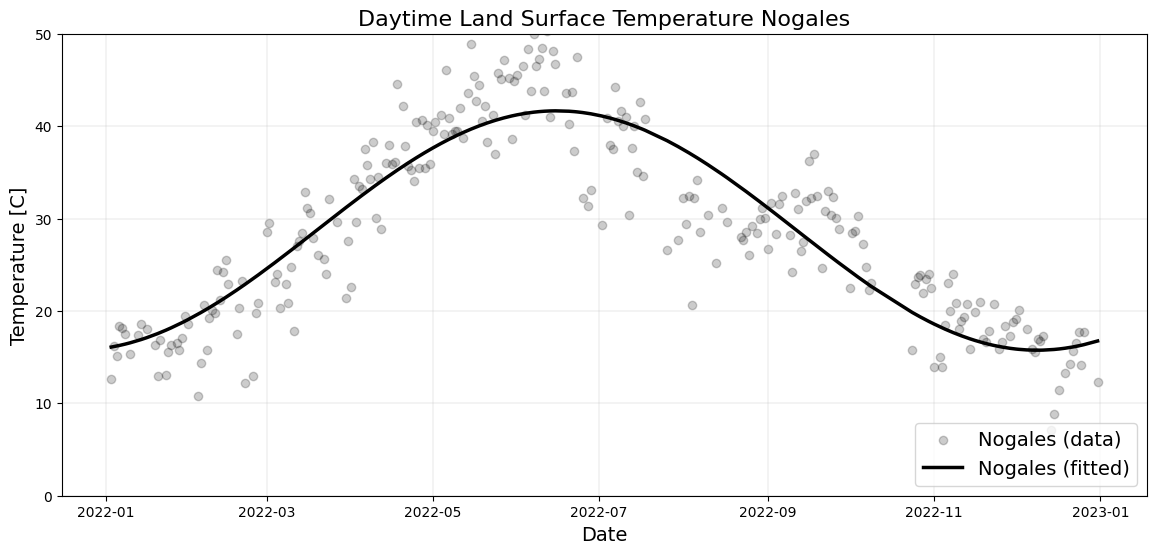

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

x_data_u = np.asanyarray(df['time'].apply(float))
y_data_u = np.asanyarray(df['LST_Day_1km'].apply(float))

fig, ax = plt.subplots(figsize=(14, 6))
ax.scatter(df['datetime'], df['LST_Day_1km'],
           c='black', alpha=0.2, label='Nogales (data)')

def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000
phi = 2*np.pi*4*30.5*3600*1000/tau

params_u, params_covariance_u = optimize.curve_fit(
    fit_func, x_data_u, y_data_u, p0=[lst0, delta_lst, tau, phi])

ax.plot(df['datetime'],
        fit_func(x_data_u, params_u[0], params_u[1], params_u[2], params_u[3]),
        label='Nogales (fitted)', color='black', lw=2.5)

ax.set_title('Daytime Land Surface Temperature Nogales', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-0, 50)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()

In [53]:
import pandas as pd
df = pd.DataFrame(lst_Imuris_full) #Convert list to dataframe
headers = df.iloc[0]   # Rearrange the header.
df = pd.DataFrame(df.values[1:], columns=headers)   # Rearrange the header.
df = df[['longitude', 'latitude', 'time', "LST_Day_1km" ]].dropna() # Remove rows with null data.
df[ "LST_Day_1km"] = pd.to_numeric(df[ "LST_Day_1km"], errors='coerce')    # Convert to numeric values.
df['datetime'] = pd.to_datetime(df['time'], unit='ms')  # Convert datetime to datetime values.
df = df[['time','datetime',  "LST_Day_1km"   ]] # take interest part
df.head()

,time,datetime,LST_Day_1km
1,1641081600000,2022-01-02,14236
2,1641168000000,2022-01-03,14358
3,1641254400000,2022-01-04,14352
4,1641340800000,2022-01-05,14519
5,1641427200000,2022-01-06,14693


In [54]:
def kelvin_to_celcius(t_kelvin):
    t_celsius =  t_kelvin*0.02 - 273.15
    return t_celsius
df['LST_Day_1km'] = df['LST_Day_1km'].apply(kelvin_to_celcius)
df.head()

,time,datetime,LST_Day_1km
1,1641081600000,2022-01-02,11.57
2,1641168000000,2022-01-03,14.01
3,1641254400000,2022-01-04,13.89
4,1641340800000,2022-01-05,17.23
5,1641427200000,2022-01-06,20.71


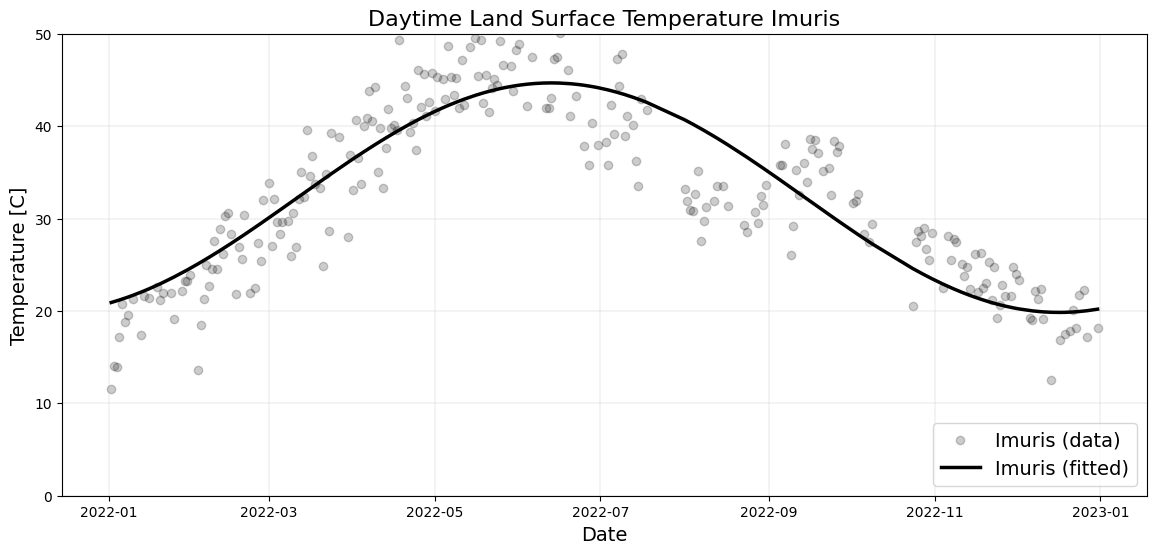

In [55]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import optimize

x_data_u = np.asanyarray(df['time'].apply(float))
y_data_u = np.asanyarray(df['LST_Day_1km'].apply(float))

fig, ax = plt.subplots(figsize=(14, 6))
ax.scatter(df['datetime'], df['LST_Day_1km'],
           c='black', alpha=0.2, label='Imuris (data)')

def fit_func(t, lst0, delta_lst, tau, phi):
    return lst0 + (delta_lst/2)*np.sin(2*np.pi*t/tau + phi)

lst0 = 20
delta_lst = 40
tau = 365*24*3600*1000
phi = 2*np.pi*4*30.5*3600*1000/tau

params_u, params_covariance_u = optimize.curve_fit(
    fit_func, x_data_u, y_data_u, p0=[lst0, delta_lst, tau, phi])

ax.plot(df['datetime'],
        fit_func(x_data_u, params_u[0], params_u[1], params_u[2], params_u[3]),
        label='Imuris (fitted)', color='black', lw=2.5)

ax.set_title('Daytime Land Surface Temperature Imuris', fontsize=16)
ax.set_xlabel('Date', fontsize=14)
ax.set_ylabel('Temperature [C]', fontsize=14)
ax.set_ylim(-0, 50)
ax.grid(lw=0.2)
ax.legend(fontsize=14, loc='lower right')

plt.show()